In [1]:
import sys
sys.path.append("../PSI-MI/")
from miHierarchy import *

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import math
from collections import Counter

## Function of gene ID conversion (2025-04-19)

In [2]:
geneName = pd.read_csv(r'../../data/Biomart_geneid/Biomart_geneid_worm.txt',
                       sep="\t",
                       header=None)
geneName.columns = ['ID', 'Symbol']
id_count = dict(Counter(geneName['ID'].tolist()))
id_retain = [k for k,v in id_count.items() if v == 1]

geneName2 = geneName[geneName['ID'].isin(id_retain)]
id_name = dict(zip(geneName2['ID'], geneName2['Symbol']))

def id2name(id):
    if id in id_name.keys():
        return id_name[id]
    else:
        return 0

In [3]:
id2name('13179121')

'Y48G1C.13'

# Worm PPI data integration from different databases

## Raw data extraction (2025-04-19)
### BioGRID

In [4]:
gene_A = []
gene_B = []
method = []
pubmed = []
interaction_type = []
with open(r'../../data/PPIs/BIOGRID-ORGANISM-4.4.203.mitab/BIOGRID-ORGANISM-Caenorhabditis_elegans-4.4.203.mitab.txt') as f:
    for row in f:
        if row.startswith("#ID"):
            pass
        else:
            col = row.split("\t")
            if col[9] == 'taxid:6239' and col[10] == 'taxid:6239':
                gene_A.append(id2name(col[0].replace('entrez gene/locuslink:', '')))
                gene_B.append(id2name(col[1].replace('entrez gene/locuslink:', '')))
                method.append(col[6].replace('psi-mi:"', '').replace('"', ''))
                pubmed.append(col[8])
                interaction_type.append(col[11].replace('psi-mi:"', '').replace('"', ''))
                
biogrid = pd.DataFrame({'gene_A': gene_A, 'gene_B': gene_B,
                         'interaction_detection_method': method,
                         'pubmed_id': pubmed,
                         'interaction_type': interaction_type,
                         'database': ['BioGRID'] * len(gene_A)})

In [5]:
biogrid.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,interaction_type,database
0,soc-2,W07G4.5,MI:0018(two hybrid),pubmed:14704431,MI:0407(direct interaction),BioGRID
1,soc-2,let-60,MI:0018(two hybrid),pubmed:14704431,MI:0407(direct interaction),BioGRID
2,gna-1,acly-2,MI:0018(two hybrid),pubmed:14704431,MI:0407(direct interaction),BioGRID
3,gna-1,dlg-1,MI:0018(two hybrid),pubmed:14704431,MI:0407(direct interaction),BioGRID
4,gna-1,pal-1,MI:0018(two hybrid),pubmed:14704431,MI:0407(direct interaction),BioGRID


In [6]:
biogrid.shape

(39125, 6)

### IntAct

In [7]:
gene_A = []
gene_B = []
method = []
pubmed = []
interaction_type = []
with open(r'../../data/PPIs/IntAct/intact.txt') as f:
    for row in f:
        if row.startswith("#ID"):
            pass
        else:
            col = row.strip().split('\t')
            if re.search(r'pubmed:unassigned[0-9]+', col[8]):  # pubmed:unassigned
                pass
            else:
                if col[9] == 'taxid:6239(caeel)|taxid:6239(Caenorhabditis elegans)' and \
                col[10] == 'taxid:6239(caeel)|taxid:6239(Caenorhabditis elegans)':
                    gene_A.append(id2name(re.split('[:-]', col[0])[1]))
                    gene_B.append(id2name(re.split('[:-]', col[1])[1]))
                    method.append(col[6].replace('psi-mi:"', '').replace('"', ''))
                    pubmed.append(re.search(r'(.*)(pubmed:[0-9]+)(\D*)(.*)', col[8]).group(2))
                    interaction_type.append(col[11].replace('psi-mi:"', '').replace('"', ''))
                
intact = pd.DataFrame({'gene_A': gene_A, 'gene_B': gene_B,
                         'interaction_detection_method': method,
                         'pubmed_id': pubmed,
                         'interaction_type': interaction_type,
                         'database': ['IntAct'] * len(gene_A)})

In [8]:
intact.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,interaction_type,database
0,tra-1,tra-2,MI:0018(two hybrid),pubmed:11250902,MI:0915(physical association),IntAct
1,tra-2,tra-1,MI:0018(two hybrid),pubmed:11250902,MI:0915(physical association),IntAct
2,tra-1,tra-2,MI:0018(two hybrid),pubmed:11250902,MI:0915(physical association),IntAct
3,tra-2,tra-1,MI:0018(two hybrid),pubmed:11250902,MI:0915(physical association),IntAct
4,tra-1,tra-2,MI:0007(anti tag coimmunoprecipitation),pubmed:11250902,MI:0915(physical association),IntAct


In [9]:
intact.shape

(42793, 6)

### DIP

In [35]:
gene_A = []
gene_B = []
method = []
pubmed = []
interaction_type = []
with open(r'../../data/PPIs/DIP/Celeg20170205.txt') as f:
    for row in f:
        if row.startswith("ID"):
            pass
        else:
            col = row.strip().split("\t")
            if col[9] == 'taxid:6239(Caenorhabditis elegans)' and col[10] == 'taxid:6239(Caenorhabditis elegans)':
                a = re.split('\\|', col[0])[-1]
                b = re.split('\\|', col[1])[-1]
                #print(a + "\t" + b)
                if bool(re.search("DIP", a)) or bool(re.search("DIP", b)):
                    pass
                else:
                    gene_A.append(id2name(re.split(':', a)[1]))
                    gene_B.append(id2name(re.split(':', b)[1]))
                    method.append(col[6]) # MI:0809,(bimolecular fluorescence complementation) [removing ',' manually]
                    pubmed.append(re.sub(r'\|pubmed:DIP-[0-9]+', '', col[8]))
                    interaction_type.append(col[11])
                        
dip = pd.DataFrame({'gene_A': gene_A, 'gene_B': gene_B,
                         'interaction_detection_method': method,
                         'pubmed_id': pubmed,
                         'interaction_type': interaction_type,
                         'database': ['DIP'] * len(gene_A)})

In [36]:
dip.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,interaction_type,database
0,ced-9,ced-4,MI:0007(anti tag coimmunoprecipitation)|MI:000...,pubmed:9027312S|pubmed:9027312S|pubmed:9027312S,MI:0915(physical association)|MI:0915(physical...,DIP
1,ced-3,ced-4,MI:0007(anti tag coimmunoprecipitation)|MI:000...,pubmed:9027312S|pubmed:9027312S|pubmed:1693887...,MI:0915(physical association)|MI:0915(physical...,DIP
2,let-23,0,MI:0401(biochemical),pubmed:7652556S,MI:0218(physical interaction),DIP
3,0,crm-1,MI:0018(two hybrid),pubmed:14704431S,MI:0218(physical interaction),DIP
4,vdac-1,crm-1,MI:0018(two hybrid),pubmed:14704431S,MI:0218(physical interaction),DIP


In [37]:
dip.shape

(4040, 6)

In [38]:
dip2 = dip[['gene_A', 'interaction_detection_method']]
dip2 = dip2.drop('interaction_detection_method', axis=1).\
    join(dip2['interaction_detection_method'].str.split('|', expand = True).\
         stack().reset_index(level=1, drop=True).rename('interaction_detection_method'))

dip3 = dip[['gene_B', 'pubmed_id']]
dip3 = dip3.drop('pubmed_id', axis=1).\
    join(dip3['pubmed_id'].str.split('|', expand = True).\
         stack().reset_index(level=1, drop=True).rename('pubmed_id'))

dip4 = dip[['interaction_type', 'database']]
dip4 = dip4.drop('interaction_type', axis=1).\
    join(dip4['interaction_type'].str.split('|', expand = True).\
         stack().reset_index(level=1, drop=True).rename('interaction_type'))

dip5 = pd.concat([dip2, dip3, dip4], axis=1)
dip5 = dip5[['gene_A', 'gene_B', 'interaction_detection_method', 'pubmed_id',
             'interaction_type', 'database']]
dip5.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,interaction_type,database
0,ced-9,ced-4,MI:0007(anti tag coimmunoprecipitation),pubmed:9027312S,MI:0915(physical association),DIP
0,ced-9,ced-4,MI:0007(anti tag coimmunoprecipitation),pubmed:9027312S,MI:0915(physical association),DIP
0,ced-9,ced-4,MI:0007(anti tag coimmunoprecipitation),pubmed:9027312S,MI:0915(physical association),DIP
1,ced-3,ced-4,MI:0007(anti tag coimmunoprecipitation),pubmed:9027312S,MI:0915(physical association),DIP
1,ced-3,ced-4,MI:0007(anti tag coimmunoprecipitation),pubmed:9027312S,MI:0915(physical association),DIP


In [39]:
dip5.shape

(4222, 6)

## Intrgration

In [40]:
integrated_ppi = pd.concat([biogrid, intact, dip5])
integrated_ppi2 = integrated_ppi[(integrated_ppi.gene_A != 0) & (integrated_ppi.gene_B != 0)]
integrated_ppi2 = integrated_ppi2.drop_duplicates()
integrated_ppi2 = integrated_ppi2[integrated_ppi2.gene_A != integrated_ppi2.gene_B]
integrated_ppi2 = integrated_ppi2.iloc[:,[0,1,2,3,5]]

In [41]:
integrated_ppi.shape

(86140, 6)

In [42]:
integrated_ppi2.shape

(42603, 5)

In [43]:
integrated_ppi2.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,database
0,soc-2,W07G4.5,MI:0018(two hybrid),pubmed:14704431,BioGRID
1,soc-2,let-60,MI:0018(two hybrid),pubmed:14704431,BioGRID
2,gna-1,acly-2,MI:0018(two hybrid),pubmed:14704431,BioGRID
3,gna-1,dlg-1,MI:0018(two hybrid),pubmed:14704431,BioGRID
4,gna-1,pal-1,MI:0018(two hybrid),pubmed:14704431,BioGRID


In [23]:
def mi_grandparent(idm):
    mi = re.search(r'(MI:[0-9]+)(\(.*\))', idm).group(1)
    return ",".join(find_grandparent(mi))

In [45]:
integrated_ppi2['grandparent_MI'] = integrated_ppi2['interaction_detection_method'].apply(mi_grandparent)
integrated_ppi2 = integrated_ppi2[integrated_ppi2.grandparent_MI != "-"]

In [46]:
integrated_ppi2.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,database,grandparent_MI
0,soc-2,W07G4.5,MI:0018(two hybrid),pubmed:14704431,BioGRID,MI:0090
1,soc-2,let-60,MI:0018(two hybrid),pubmed:14704431,BioGRID,MI:0090
2,gna-1,acly-2,MI:0018(two hybrid),pubmed:14704431,BioGRID,MI:0090
3,gna-1,dlg-1,MI:0018(two hybrid),pubmed:14704431,BioGRID,MI:0090
4,gna-1,pal-1,MI:0018(two hybrid),pubmed:14704431,BioGRID,MI:0090


In [47]:
integrated_ppi2.shape

(42599, 6)

In [48]:
mi_remove = ['MI:0254', 'MI:1088', 'MI:0255'] # genetic interference, phenotype-based detection assay, post transcriptional interference
integrated_ppi2 = integrated_ppi2[~integrated_ppi2.grandparent_MI.isin(mi_remove)]

In [49]:
integrated_ppi2.shape

(40279, 6)

### 1. Divide the PPIs into high-through (HT) and low-through (LT) (2025-04-19)

In [50]:
integrated_ppi3 = integrated_ppi2[['gene_B', 'gene_A', 'interaction_detection_method', 
                                   'pubmed_id', 'database']]
integrated_ppi3.columns = integrated_ppi2.columns[0:5]
integrated_ppi3 = pd.concat([integrated_ppi2.iloc[:,0:5], integrated_ppi3], 
                            axis = 0, ignore_index = True)
integrated_ppi3 = integrated_ppi3.drop_duplicates()

In [51]:
integrated_ppi3.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,database
0,soc-2,W07G4.5,MI:0018(two hybrid),pubmed:14704431,BioGRID
1,soc-2,let-60,MI:0018(two hybrid),pubmed:14704431,BioGRID
2,gna-1,acly-2,MI:0018(two hybrid),pubmed:14704431,BioGRID
3,gna-1,dlg-1,MI:0018(two hybrid),pubmed:14704431,BioGRID
4,gna-1,pal-1,MI:0018(two hybrid),pubmed:14704431,BioGRID


In [52]:
integrated_ppi3.shape

(79554, 5)

In [53]:
throughput = integrated_ppi3[['gene_A', 'gene_B', 'pubmed_id']]
throughput = throughput.drop_duplicates()

pubmeds = throughput['pubmed_id'].tolist()
pubmed_num = Counter(pubmeds)

def ht_lt(pubmed):
    if pubmed_num[pubmed] >= 200:
        return "HT"
    else:
        return "LT"

In [54]:
throughput.shape

(70952, 3)

In [55]:
integrated_ppi3['throughput'] = integrated_ppi3['pubmed_id'].apply(ht_lt)

In [56]:
integrated_ppi3.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,database,throughput
0,soc-2,W07G4.5,MI:0018(two hybrid),pubmed:14704431,BioGRID,HT
1,soc-2,let-60,MI:0018(two hybrid),pubmed:14704431,BioGRID,HT
2,gna-1,acly-2,MI:0018(two hybrid),pubmed:14704431,BioGRID,HT
3,gna-1,dlg-1,MI:0018(two hybrid),pubmed:14704431,BioGRID,HT
4,gna-1,pal-1,MI:0018(two hybrid),pubmed:14704431,BioGRID,HT


### 2. Combine the same interaction from different literatures, experimental scales, databases and method (PSI-MI)

In [57]:
def comb(df):
    return ';'.join(df.values)

In [58]:
def inter_comb(name):
    ppi = integrated_ppi3[['gene_A','gene_B',name]]
    ppi = ppi.drop_duplicates()
    ppi2 = ppi.groupby(['gene_A','gene_B'])[name].apply(comb)
    interaction_list = []
    for i in range(len(ppi2.index)):
        interaction_list.append(ppi2.index[i])
    ppi3 = pd.DataFrame(interaction_list)
    ppi3.columns = ppi2.index.names
    ppi3[name] = ppi2.values
    return ppi3

In [59]:
integrated_ppi4 = pd.DataFrame({'gene_A':[], 'gene_B':[]})
for name in integrated_ppi3.columns[2:6].to_list():
    ppi = inter_comb(name)
    integrated_ppi4 = pd.merge(integrated_ppi4, ppi, how='right',
                               on=['gene_A', 'gene_B'])

In [60]:
integrated_ppi4.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,database,throughput
0,AC3.5,sti-1,MI:0006(anti bait coimmunoprecipitation),pubmed:19467242,IntAct,LT
1,AH9.6,C01G10.10,MI:0401(biochemical),pubmed:31308550,BioGRID,HT
2,AH9.6,C47D12.2,MI:0401(biochemical),pubmed:31308550,BioGRID,HT
3,AH9.6,csn-1,MI:0401(biochemical),pubmed:31308550,BioGRID,HT
4,AH9.6,plc-3,MI:0401(biochemical),pubmed:31308550,BioGRID,HT


In [61]:
Counter(integrated_ppi4['throughput'].tolist())

Counter({'HT': 54826, 'LT': 9068, 'HT;LT': 716, 'LT;HT': 524})

In [62]:
integrated_ppi4.shape

(65134, 6)

### 3. Remove the replicated interaction pairs (retain A-B, but not B-A) (2025-04-19)

In [63]:
interaction = []
gene_A = []
gene_B = []
interaction_detection_method = []
pubmed_id = []
database = []
throughput = []

for i in range(integrated_ppi4.shape[0]):
    if integrated_ppi4.iloc[i,1] + '-' + integrated_ppi4.iloc[i,0] in interaction:
        pass
    else:
        interaction.append(integrated_ppi4.iloc[i,0] + '-' + integrated_ppi4.iloc[i,1])
        gene_A.append(integrated_ppi4.iloc[i,0])
        gene_B.append(integrated_ppi4.iloc[i,1])
        interaction_detection_method.append(integrated_ppi4.iloc[i,2])
        pubmed_id.append(integrated_ppi4.iloc[i,3])
        database.append(integrated_ppi4.iloc[i,4])
        throughput.append(';'.join(sorted(integrated_ppi4.iloc[i,5].split(';'))))
        
integrated_ppi5 = pd.DataFrame({'Gene_A': gene_A, 
                                'Gene_B': gene_B, 
                                'Interaction_detection_method': interaction_detection_method, 
                                'Pubmed_id': pubmed_id,
                                'Database': database,
                                'Throughput': throughput})

In [64]:
integrated_ppi5.shape

(32567, 6)

In [65]:
integrated_ppi5.head()

,Gene_A,Gene_B,Interaction_detection_method,Pubmed_id,Database,Throughput
0,AC3.5,sti-1,MI:0006(anti bait coimmunoprecipitation),pubmed:19467242,IntAct,LT
1,AH9.6,C01G10.10,MI:0401(biochemical),pubmed:31308550,BioGRID,HT
2,AH9.6,C47D12.2,MI:0401(biochemical),pubmed:31308550,BioGRID,HT
3,AH9.6,csn-1,MI:0401(biochemical),pubmed:31308550,BioGRID,HT
4,AH9.6,plc-3,MI:0401(biochemical),pubmed:31308550,BioGRID,HT


In [66]:
integrated_ppi5.to_csv(path_or_buf='../../result/integrated_ppi/PPI_Ce/integrated_ppi.txt',
                       index = False, sep = '\t')

In [ ]:
integrated_ppi6 = integrated_ppi5.iloc[:, :2]
integrated_ppi6.to_csv(path_or_buf='../../result/integrated_ppi_Ce.txt', 
                       header=False, index=False)

### 4. Basic statistics

In [67]:
"""The number of PPIs supported by different scale experiments"""
scale_num = pd.DataFrame.from_dict(Counter(integrated_ppi5['Throughput'].tolist()), 
                                   orient="index", columns = ['Number'])
scale_num = scale_num.reset_index().rename(columns = {'index': 'Throughput'})

In [68]:
scale_num

,Throughput,Number
0,LT,4534
1,HT,27413
2,HT;LT,620


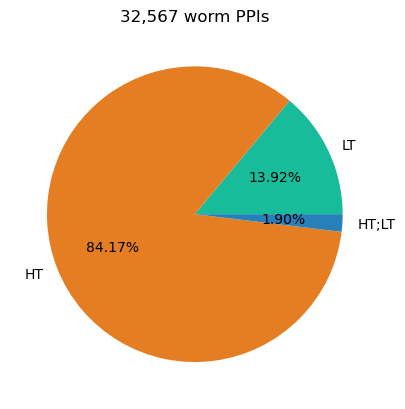

In [69]:
#from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.pie(scale_num['Number'].tolist(), 
        labels=scale_num['Throughput'], 
        autopct='%1.2f%%', 
        colors=['#18BC9B', '#E57E23', '#2780B9'])
plt.title('32,567 worm PPIs')
#plt.axis('equal')
#plt.show()
plt.savefig('../../result/integrated_ppi/PPI_Ce/throughput_number.pdf')

# Network analysis

In [70]:
import networkx as nx

### 1. Network topological properties (2025-04-19)

In [71]:
ppi = pd.read_csv(r'../../result/integrated_ppi/PPI_Ce/integrated_ppi.txt', sep="\t")

In [72]:
G = nx.from_pandas_edgelist(ppi[['Gene_A', 'Gene_B']], source='Gene_A', target='Gene_B', 
                            edge_attr=None, create_using=None)

In [73]:
"""Global network"""
print("Number of nodes N\t", len(list(G.nodes)))
print("Number of edges N\t", len(list(G.edges)))

Number of nodes N	 7776
Number of edges N	 32567


In [74]:
"""The largest connected component"""
largest_components=max(nx.connected_components(G),key=len) # genes in the largest connected component
S = [G.subgraph(c).copy() for c in nx.connected_components(G)] # all the components
max_S = nx.to_pandas_edgelist(S[0]) # the largest connected component
max_S.to_csv(path_or_buf='../../result/integrated_ppi/PPI_Ce/integrated_ppi_largest_component.txt', index = 0, sep = '\t', header=0)

In [75]:
"""Global network"""
print("Number of nodes N\t", len(list(S[0].nodes)))
print("Number of edges N\t", len(list(S[0].edges)))
print("Mean degree <k>\t", len(list(S[0].edges))*2/len(list(S[0].nodes)))
print("Mean clustering <c>\t", nx.average_clustering(S[0]))
print("Mean distance <d>\t", nx.average_shortest_path_length(S[0]))
print("Diameter dmax\t", nx.diameter(S[0]))

Number of nodes N	 7502
Number of edges N	 32411
Mean degree <k>	 8.640629165555852
Mean clustering <c>	 0.12304697191220605
Mean distance <d>	 4.279445687344771
Diameter dmax	 13


In [76]:
nodes = sorted(list(G.nodes()))

Degree = nx.degree(G)  # Degree
k = [Degree[node] for node in nodes]

Betweenness_centrality = nx.betweenness_centrality(G)  # Betweenness
BC = [Betweenness_centrality[node] for node in nodes]

Eigenvector_centrality = nx.eigenvector_centrality(G)  # Eigenvector centrality
x = [Eigenvector_centrality[node] for node in nodes]

Clustering_coefficient = nx.clustering(G) # local clustering coefficient
C = [Clustering_coefficient[node] for node in nodes]

Assortativity = nx.average_neighbor_degree(G) # The average neighborhood degree of a node
NC = [Assortativity[node] for node in nodes]

Closeness_centrality = nx.closeness_centrality(G) # reciprocal of the average shortest path distance
SP = [Closeness_centrality[node] for node in nodes]

node_info = pd.DataFrame({'Gene': nodes,
                          'Degree': k, 
                          'Betweenness_centrality': BC,
                          'Eigenvector_centrality': x,
                          'Clustering_coefficient': C,
                          'Assortativity': NC,
                          'Closeness_centrality': SP})

In [77]:
node_info.head()

,Gene,Degree,Betweenness_centrality,Eigenvector_centrality,Clustering_coefficient,Assortativity,Closeness_centrality
0,AC3.5,1,0.000000e+00,0.000077,0.000000,37.000000,0.221793
1,AH9.6,6,8.549579e-05,0.000060,0.066667,13.500000,0.231818
2,B0001.2,3,0.000000e+00,0.000742,1.000000,51.333333,0.234995
3,B0001.4,2,0.000000e+00,0.000067,1.000000,207.500000,0.249729
4,B0001.7,2,6.918700e-07,0.000004,0.000000,7.000000,0.206785


In [78]:
node_info.shape

(7776, 7)

In [79]:
node_info.to_csv(path_or_buf = '../../result/integrated_ppi/PPI_Ce/node_centrality.txt', index=False, sep='\t')

### 2. Degree distribution

In [80]:
degree_freq = Counter(node_info['Degree'].tolist())

In [81]:
log10d = []
log10f = []
for i in degree_freq:
    log10d.append(math.log10(i))
    log10f.append(math.log10(degree_freq[i]/node_info.shape[0]))

In [82]:
from sklearn.linear_model import LinearRegression

In [83]:
regressor = LinearRegression()
regressor = regressor.fit(np.reshape(log10d, (-1, 1)), np.reshape(log10f, (-1, 1)))
print(regressor.coef_, regressor.intercept_)

[[-1.67044284]] [-0.19002179]


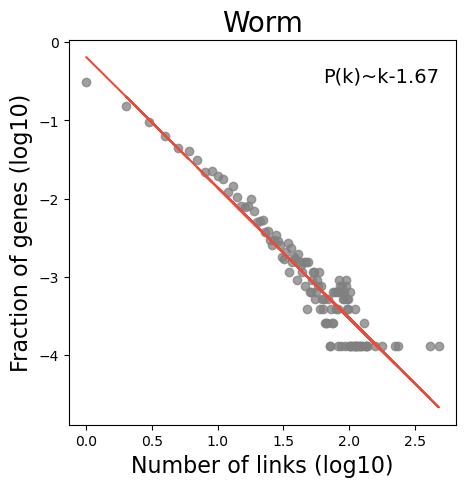

In [84]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.figure(figsize=(5, 5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title("Worm", fontsize=20)
plt.xlabel("Number of links (log10)", fontsize=16)
plt.ylabel("Fraction of genes (log10)", fontsize=16)

plt.scatter(log10d, log10f, c="grey", alpha=0.75)
plt.plot(np.reshape(log10d, (-1, 1)), 
         regressor.predict(np.reshape(log10d, (-1, 1))), 
         c="#E74C3C")

plt.text(1.8, -0.5, 'P(k)~k-1.67', size = 14)
#plt.show()

plt.savefig('../../result/integrated_ppi/PPI_Ce/degree_distribution.pdf')